# Exercises

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [1]:
import os
import pickle
import sys
import timeit

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pywt import cwt, scale2frequency
from scipy.stats import zscore

sys.path.append(os.path.abspath("code"))
palette = sns.color_palette("tab10")

sns.set_theme("paper", palette=palette, style="whitegrid", font_scale=1.5, font="Times")

import lfp_functions as lf

### 1.1. Load dataset and extract a segment

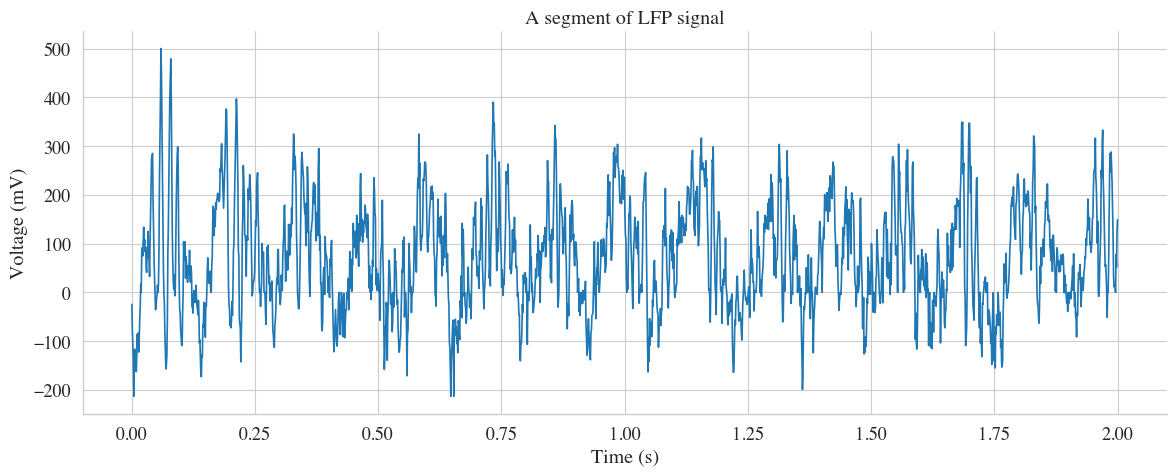

In [2]:
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
fs = lfp_data['sampling_rate']

# Extract a segment of LFP (first 2 seconds)
duration = 2
n_samples = int(duration * fs)
time = np.linspace(0, duration, n_samples)
signal = lfp[:n_samples]

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(time, signal)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('A segment of LFP signal')
sns.despine()
plt.tight_layout()
plt.show()

### 1.2. Bandpass filtering

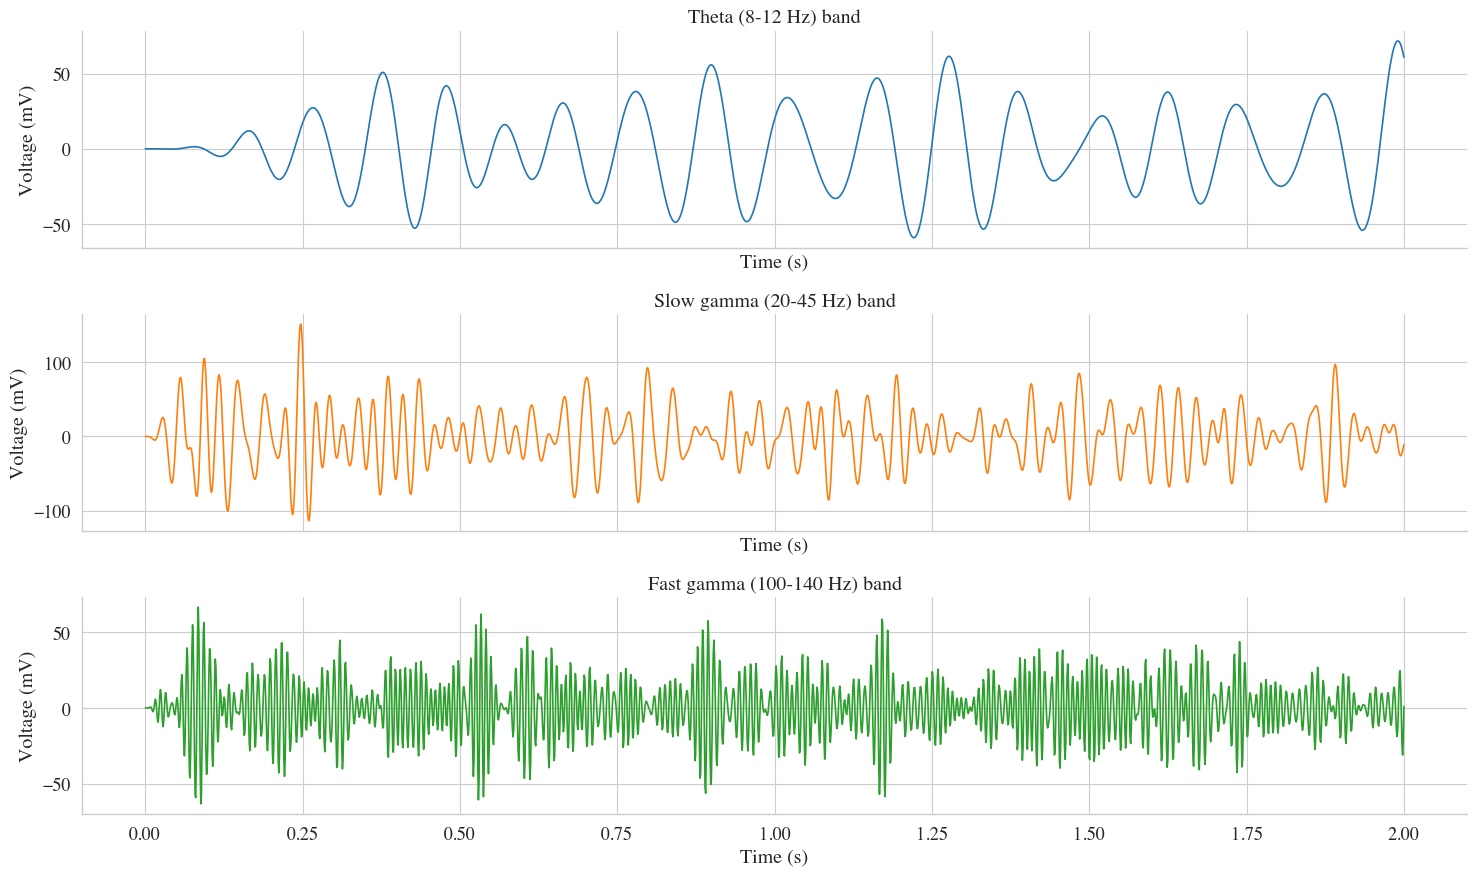

In [3]:
# Define frequency bands
bands = {
    'Theta (8-12 Hz)':  (8, 12),
    'Slow gamma (20-45 Hz)': (20, 45),
    'Fast gamma (100-140 Hz)': (100, 140),
}

# Bandpass filtering
fig, axes = plt.subplots(len(bands), 1, figsize=(15, 3 * len(bands)), sharex=True)
for (label, (low, high)), col, ax in zip(bands.items(), palette, axes):
    filtered_signal = lf.bandpass_filter(signal, low, high, sampling_rate=fs)
    ax.plot(time, filtered_signal, color=col)
    ax.set_title(f'{label} band')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (mV)')
sns.despine()
plt.tight_layout()
plt.show()

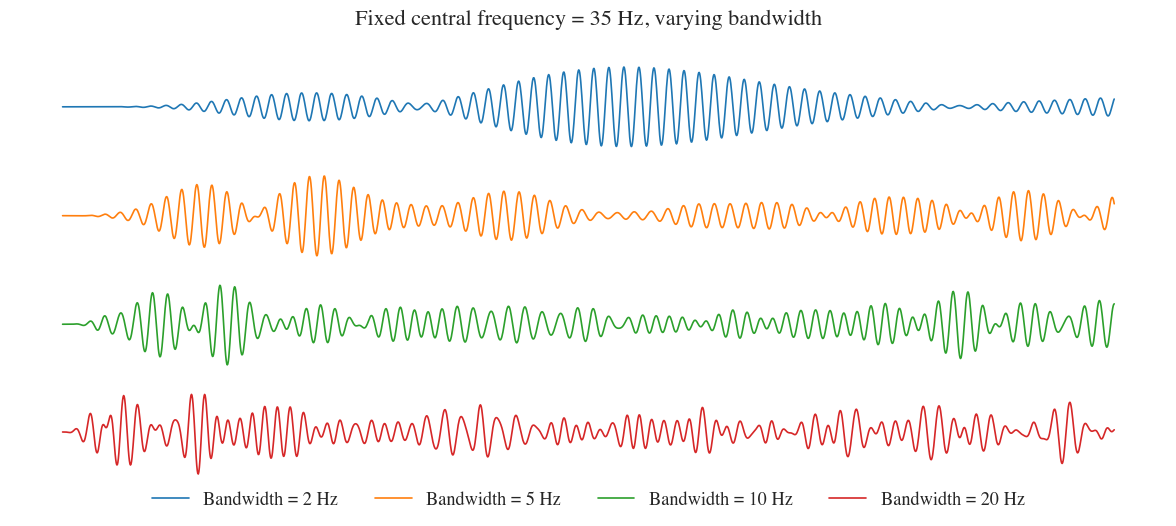

In [4]:
##### Fix central frequency and varying bandwidth #####

f0 = 35
widths = [2, 5, 10, 20]

fig, axes = plt.subplots(len(widths), 1, figsize=(12, 5))
for ax, width, color in zip(axes, widths, palette):
    low = f0 - width / 2
    high = f0 + width / 2
    filtered_signal = lf.bandpass_filter(signal, low, high, sampling_rate=fs)
    ax.plot(time, filtered_signal, color=color, label=f'Bandwidth = {width} Hz')
    ax.axis('off')

fig.suptitle(f"Fixed central frequency = {f0} Hz, varying bandwidth", fontsize=16)
fig.legend(loc="upper center", ncol=len(widths), frameon=False, bbox_to_anchor=(0.5, 0.05))
plt.subplots_adjust(top=0.22, bottom=0.15, hspace=0.3)
plt.tight_layout()
plt.show()

When we fix the central frequency and vary bandwidth as in the above plot, we can see that:

- Narrower band width (2-5 Hz) produces a highly sinusoidal and smooth signal, but oscillations are spread over time, which indicates a poor temporal localization.
- At medium bandwidth (10 Hz), the signal begins to reflect faster temporal changes and transient dynamics, but the waveform becomes less purely sinusoidal.
- With wide bandwidth (20 Hz), the signal becomes even noisier and shows less regular oscillations. It now contains more frequency components, which allow more dynamics, but frequency specificity is lost.

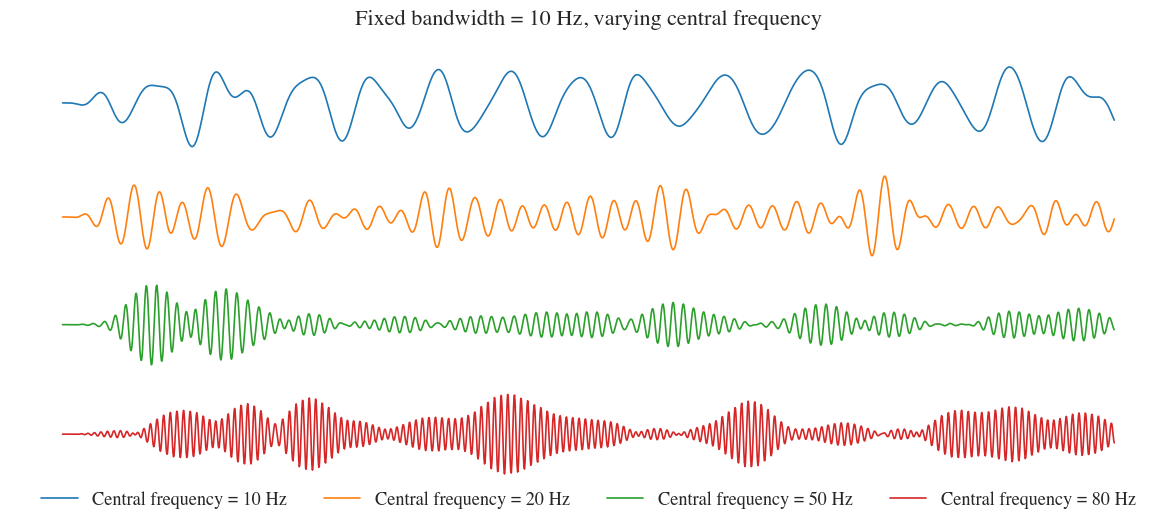

In [5]:
##### Fix bandwidth and varying central frequency #####

width = 10
freqs = [10, 20, 50, 80]

fig, axes = plt.subplots(len(widths), 1, figsize=(12, 5))
for ax, f0, color in zip(axes, freqs, palette):
    low = f0 - width / 2
    high = f0 + width / 2
    filtered_signal = lf.bandpass_filter(signal, low, high, sampling_rate=fs)
    ax.plot(time, filtered_signal, color=color,
            label=f'Central frequency = {f0} Hz')
    ax.axis('off')

fig.suptitle(f"Fixed bandwidth = {width} Hz, varying central frequency", fontsize=16)
fig.legend(loc="upper center", ncol=len(widths),
           frameon=False, bbox_to_anchor=(0.5, 0.05))
plt.subplots_adjust(top=0.22, bottom=0.15, hspace=0.3)
plt.tight_layout()
plt.show()

When we fix bandwidth, and vary the central frequency, we can see that as central frequency increases, the oscillation frequency of the signal increases. This helps to capture faster, more transient events. Specifically, the filtered signal becomes more sensitive to noise or sharp signal changes, especially in high-frequency bands (50 Hz and 80 Hz).

### 1.3. Experiment with filtering orders

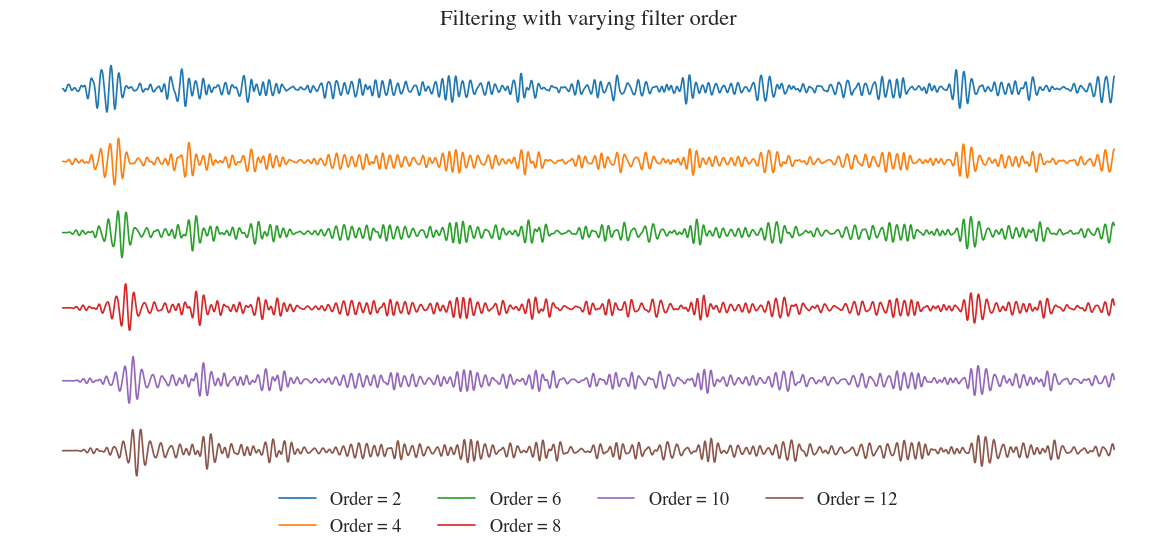

In [6]:
low = 50
high = 100
orders = [2, 4, 6, 8, 10, 12]

fig, axes = plt.subplots(len(orders), 1, figsize=(12, 5))
for ax, order, color in zip(axes, orders, palette):
    filtered_signal = lf.bandpass_filter(signal, low, high, sampling_rate=fs, filter_order=order)
    ax.plot(time, filtered_signal, color=color,
            label=f'Order = {order}')
    ax.axis('off')
fig.suptitle(f"Filtering with varying filter order", fontsize=16)
fig.legend(loc="upper center", ncol=len(widths), frameon=False, bbox_to_anchor=(0.5, 0.05))
plt.subplots_adjust(top=0.22, bottom=0.15, hspace=0.3)
plt.tight_layout()
plt.show()

In the above plot, we can see that:
- Low filter order (order = 2, 4) leads to a signal that is broader and less selective in frequency. The signal also responses quickly to changes. This shows that it has a better temporal precision, but also allows more out-of-band components.
- With a medium filter order (order = 6, 8), the signal becomes cleaner and more band-limited.
- With a high filter order (order = 10, 12), the signal is sharply filtered with a clear rhythmic structure, tightly centered in frequency. However, we can see that the signal responses slowly to changes, which indicates a poorer temporal resolution.

Thus, in short, there is a trade-off between temporal resolution and spectral sharpness: a lower filter order leads to better temporal resolution, but poor spectral sharpness; while a high filter order leads to better spectral sharpness, but poor temporal resolution.

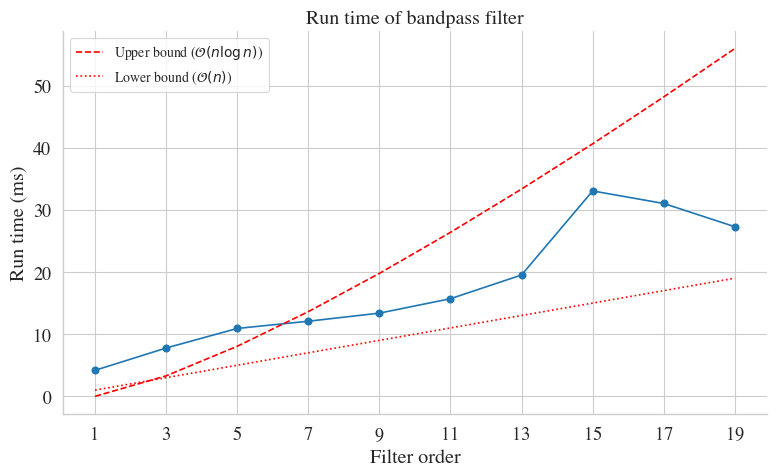

In [7]:
##### Measure run time of different filter orders #####

orders = np.arange(1, 20, 2)
run_times = []
for order in orders:
    stmt = f"lf.bandpass_filter(signal, low_f={low}, high_f={high}, sampling_rate={fs}, filter_order={order})"
    t = timeit.timeit(stmt, globals=globals(), number=2000)
    run_times.append(t/200 * 1e3)
plt.figure(figsize=(8, 5))
plt.plot(orders, run_times, marker='o')
plt.plot(orders, orders * np.log(orders), linestyle='--', color='r', label='Upper bound ($\mathcal{O}(n \log n)$)')
plt.plot(orders, orders, linestyle=':', color='r', label='Lower bound ($\mathcal{O}(n)$)')
plt.xlabel('Filter order')
plt.ylabel('Run time (ms)')
plt.title('Run time of bandpass filter')
plt.legend(loc='upper left', fontsize=10)
plt.xticks(orders)
sns.despine()
plt.tight_layout()
plt.show()

In the above plot, we can clearly see the how filtering complexity changes when we increase filter order. Visually, the measured running time increases within the bound of $\mathcal{O}(n)$ and $\mathcal{O}(nlogn)$. Thus, empirically, we can accept that the time complexity of filtering is $\mathcal{O}(nlogn)$. 

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). These are all real wavelets.
- What differences do you see with respect to the spectrum computed with the complex Morlet tranform ? Comment on why do you think this might be the case.

### 2.1. Load dataset

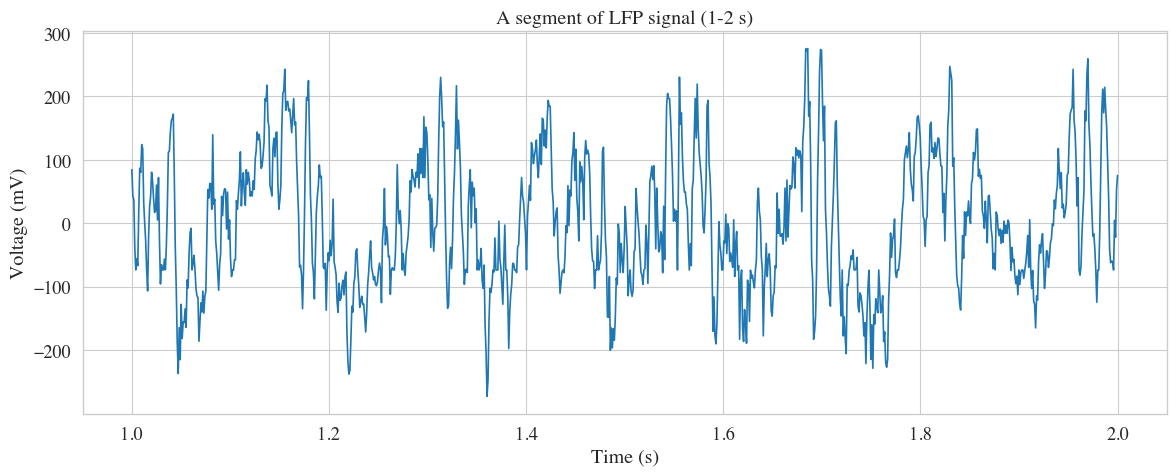

In [8]:
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
fs = lfp_data['sampling_rate']

# Extract a segment of LFP (1-2 seconds)
start = 1
end = 2
signal = lfp[int(start*fs):int(end*fs)]
signal = signal - np.mean(signal)
time = np.linspace(start, end, len(signal))

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(time, signal)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('A segment of LFP signal (1-2 s)')
plt.tight_layout()
plt.show()

### 2.2. Compute spectrogram

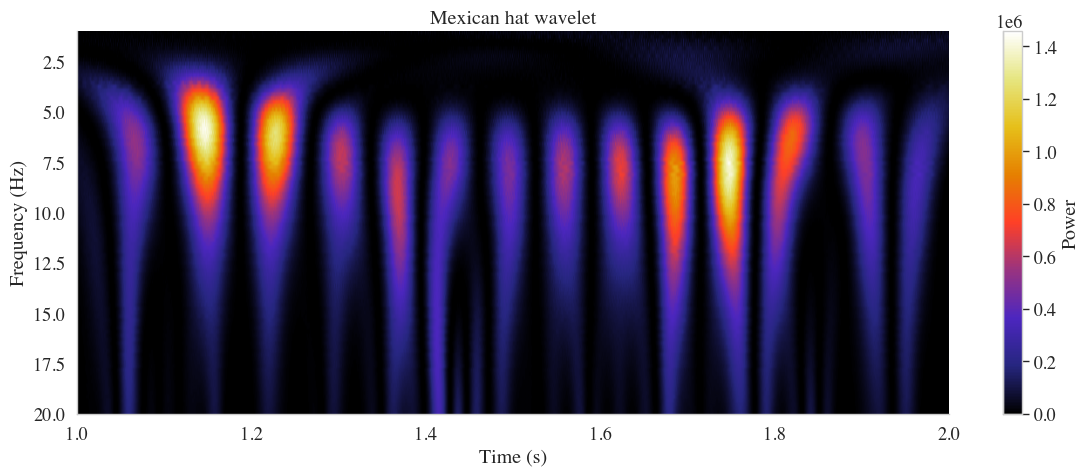

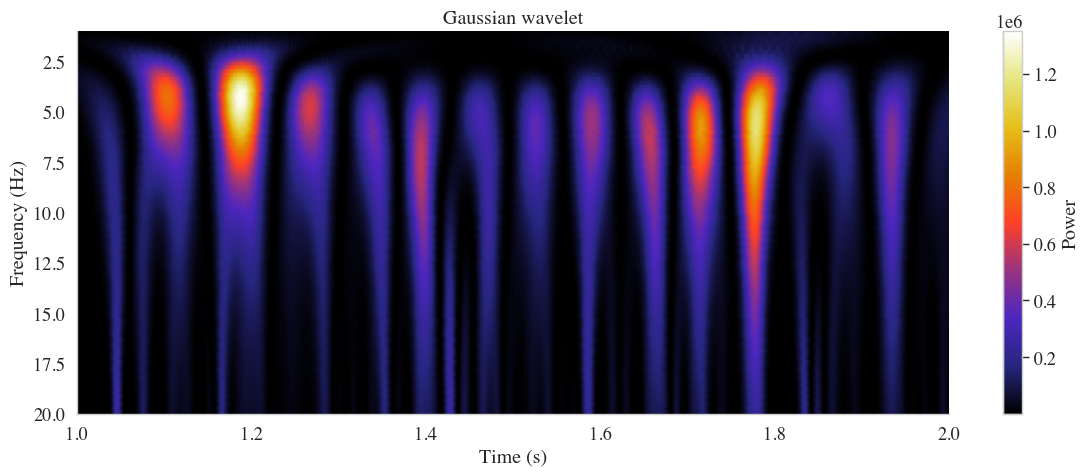

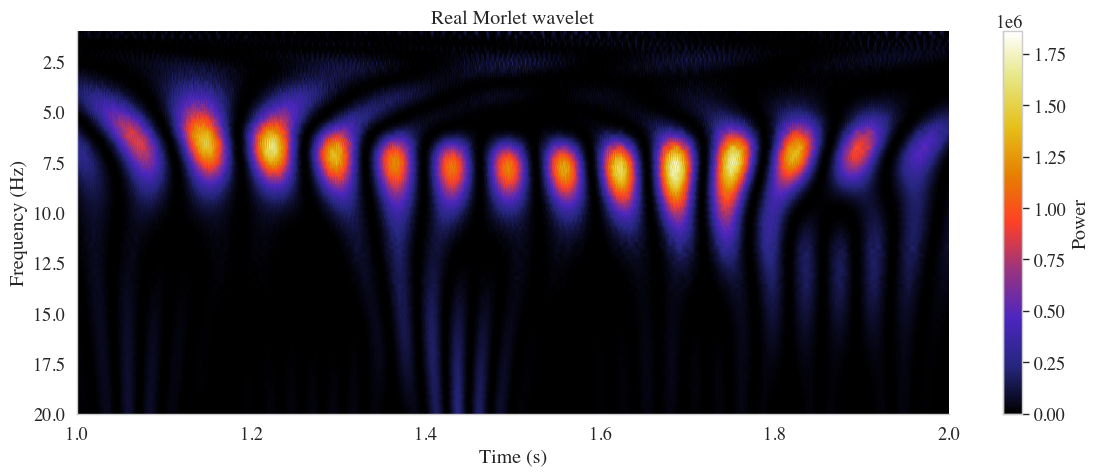

In [9]:
##### Wavelet transform #####

frequencies = np.linspace(1, 20, 100)/fs
wavelets = {
    'Mexican hat wavelet': 'mexh',
    'Gaussian wavelet': 'gaus1',
    'Real Morlet wavelet': 'morl',
}
for label, wavelet in wavelets.items():
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(signal, wavelet=wavelet, scales=scales, sampling_period=1.0/fs)
    plt.figure(figsize=(12, 5))
    plt.imshow(abs(cwtmatr)**2, extent=[start, end, frequencies[-1]*fs, frequencies[0]*fs], aspect='auto', cmap='CMRmap')
    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Power')
    plt.grid(False)
    sns.despine()
    plt.tight_layout()
    plt.show()

### 2.3 Comparison with Complex Morlet wavelet

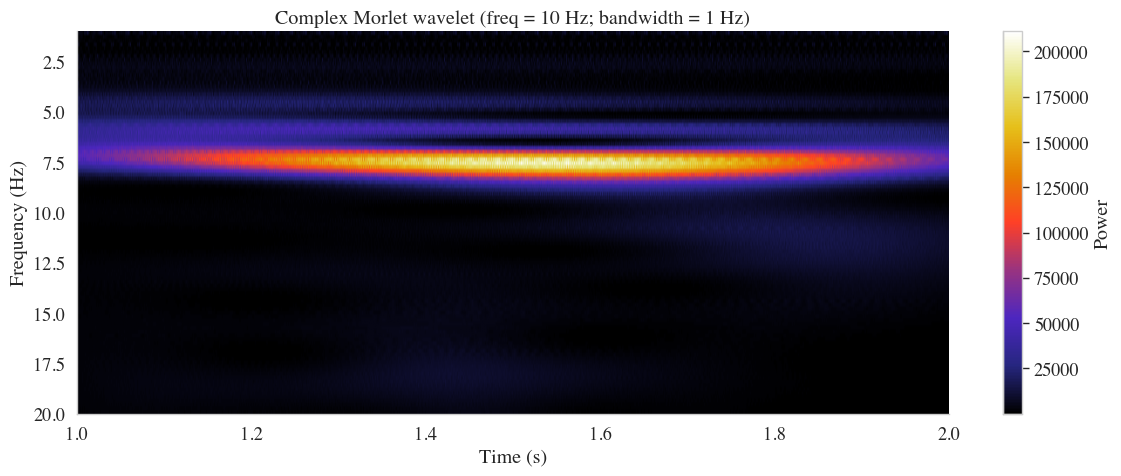

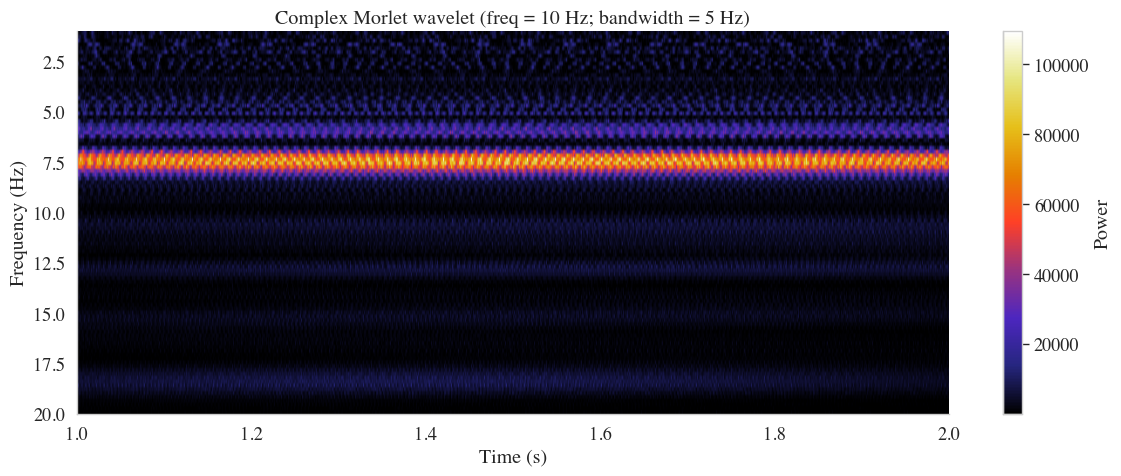

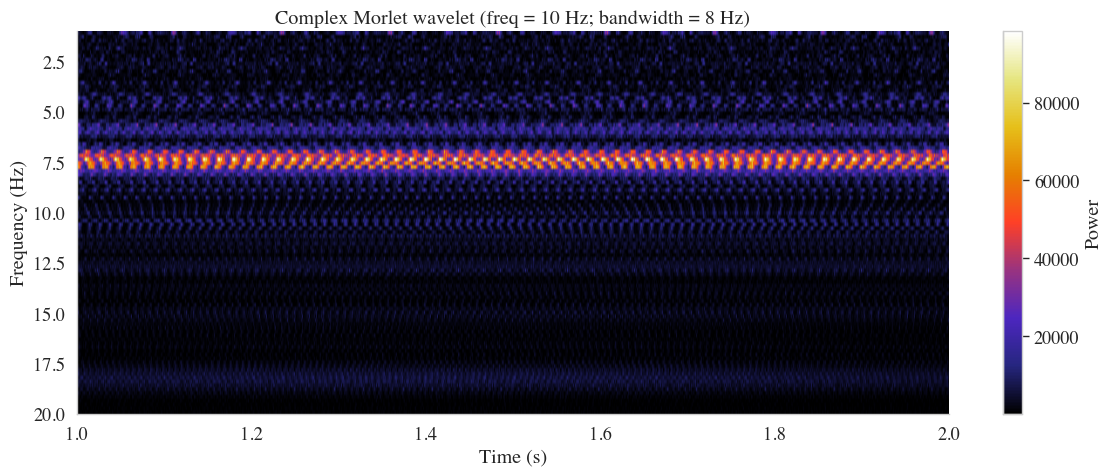

In [10]:
wavelets = {
    'Complex Morlet wavelet (freq = 10 Hz; bandwidth = 1 Hz)': 'cmor10.0-1.0',
    'Complex Morlet wavelet (freq = 10 Hz; bandwidth = 5 Hz)': 'cmor10.0-5.0',
    'Complex Morlet wavelet (freq = 10 Hz; bandwidth = 8 Hz)': 'cmor10.0-8.0',
}
for label, wavelet in wavelets.items():
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(signal, wavelet=wavelet, scales=scales, sampling_period=1.0/fs)
    plt.figure(figsize=(12, 5))
    plt.imshow(abs(cwtmatr)**2, extent=[start, end, frequencies[-1]*fs, frequencies[0]*fs], aspect='auto', cmap='CMRmap')
    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Power')
    plt.grid(False)
    sns.despine()
    plt.tight_layout()
    plt.show()

We can see a substantial difference between a real Morlet wavelet and a complex Morlet wavelet transform. In specific, real Morlet wavelet transform shows multiple distinct oscillatory bursts across time at around 7–8 Hz, and exhibits a sinusoidal oscillation. However, we can see that there are alternating bright/dark blobs at around 7 Hz and vertical spread symmetric around 7–8 Hz, which suggests that it suffers from interference artifacts and spectral leakage. 

On the other hand, the complex Morlet wavelet shows a continuous and smooth oscillation at around 7-8 Hz. It shows a high frequency precision, and responses clear transient rhythmic events. Additionally, a narrow bandwidth (e.g 1 Hz) yields high frequency resolution but poor temporal precision, while wider bandwidth (e.g. 8-10 Hz) improve temporal precision at the cost of spectral sharpness.

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/sleep_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.

### 3.1. Load dataset

In [11]:
with open('data/sleep_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
fs = lfp_data['sampling_rate']
time = np.arange(len(lfp)) / fs

### 3.2. Compute instantaneous power in theta and delta bands

In [12]:
def compute_ripple_power(signal, sampling_rate, low_f, high_f):
    signal = signal - np.mean(signal)
    frequencies = np.linspace(low_f, high_f, 50)/sampling_rate
    wavelet = 'cmor1.0-1.0'
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(signal, wavelet=wavelet, scales=scales, sampling_period=1.0/sampling_rate)
    power = np.mean(abs(cwtmatr)**2, axis=0)
    return power

In [13]:
theta_power = compute_ripple_power(lfp, fs, low_f=6, high_f=10)
delta_power = compute_ripple_power(lfp, fs, low_f=2, high_f=4)

### 3.3. Compute z-score

In [14]:
theta_z = zscore(theta_power)
delta_z = zscore(delta_power)

### 3.4. Compute power difference

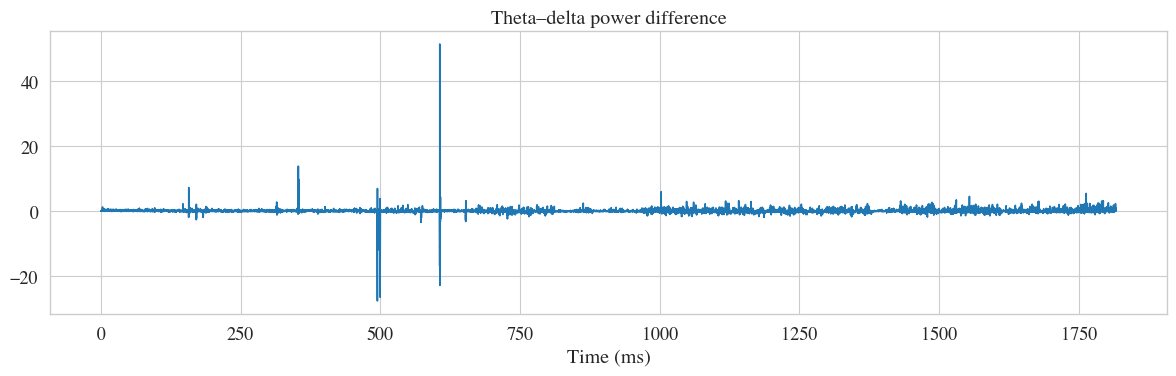

In [15]:
power_diff_z = theta_z - delta_z

plt.figure(figsize=(12, 4))
plt.plot(time, power_diff_z)
plt.xlabel('Time (ms)')
plt.title('Theta–delta power difference')
plt.tight_layout()
plt.show()

### 3.5. Extract REM and nREM sleep periods

In [16]:
def ripple_idxs(ripple_mask):
    ripple_starts = []
    ripple_ends = []
    for i in range(1, len(ripple_mask)):
        if ripple_mask[i-1] == 0 and ripple_mask[i] == 1:
            ripple_starts.append(i)
        if ripple_mask[i-1] == 1 and ripple_mask[i] == 0:
            ripple_ends.append(i)

    # handle edge cases
    if len(ripple_ends) > len(ripple_starts):
        ripple_starts = [0]+ripple_starts
    if len(ripple_ends) < len(ripple_starts):
        ripple_ends.append(len(ripple_mask))

    ripples = [np.arange(ripple_starts[i], ripple_ends[i]) for i in range(len(ripple_starts))]

    return ripples


def clean_ripples(ripples, lfp, ripple_len_th=None, amplitude_th=None):
    clean_ripples = [r for r in ripples if (len(r) > ripple_len_th and max(lfp[r]) < amplitude_th and min(lfp[r]) > -amplitude_th)]
    return clean_ripples

In [17]:
# Threshold for ripple detection
ripple_th = 0.2
rem_mask = np.asarray([True if x > ripple_th else 0 for x in power_diff_z])
nrem_mask = np.asarray([True if x < -ripple_th else 0 for x in power_diff_z])

# Extract REM and NREM ripples
rem_epochs = ripple_idxs(rem_mask)
nrem_epochs = ripple_idxs(nrem_mask)

# Clean ripples
rem_epochs = clean_ripples(rem_epochs,  lfp, ripple_len_th=30, amplitude_th=1000)
nrem_epochs = clean_ripples(nrem_epochs, lfp, ripple_len_th=30, amplitude_th=1000)

### 3.6. Examples of REM and nREM LFP signals

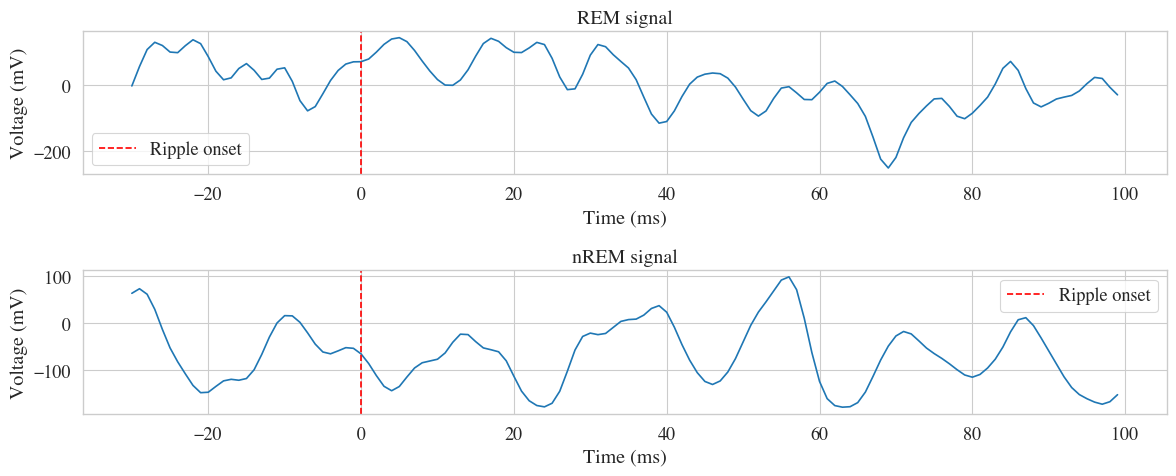

In [18]:
# Plotting
ripple_lfp = lf.bandpass_filter(lfp, 1, 200, fs)

# REM epochs
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
onset = rem_epochs[1][0]
x = np.arange(-30, 100)
y = ripple_lfp[onset-30:onset+100]
axs[0].plot(x, y)
axs[0].axvline(0, c='r', linestyle='--', label='Ripple onset')
axs[0].set_title('REM signal')
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Voltage (mV)')
axs[0].legend()

# NREM epochs
onset = nrem_epochs[1][0]
x = np.arange(-30, 100)
y = ripple_lfp[onset-30:onset+100]
axs[1].plot(x, y)
axs[1].axvline(0, c='r', linestyle='--', label='Ripple onset')
axs[1].set_title('nREM signal')
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Voltage (mV)')
axs[1].legend()

plt.tight_layout()
plt.show()

### 3.7. Explore effects of thresholding

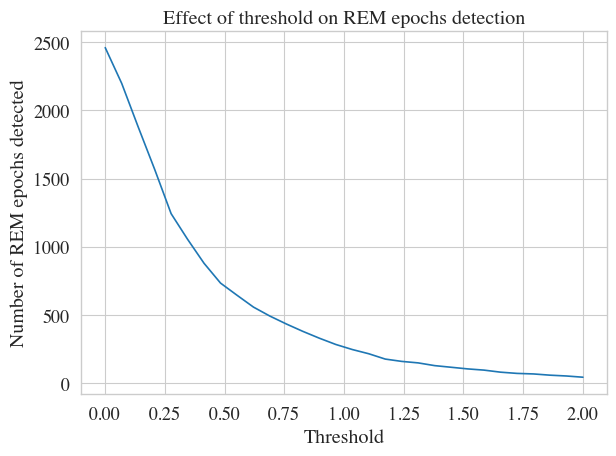

In [19]:
thresholds = np.linspace(0, 2, 30)
num_rem = []
for th in thresholds:
    rem_mask = np.asarray([True if x > th else 0 for x in power_diff_z])
    rem_epochs = ripple_idxs(rem_mask)
    rem_epochs = clean_ripples(rem_epochs, lfp, ripple_len_th=30, amplitude_th=1000)
    num_rem.append(len(rem_epochs))

plt.figure()
plt.plot(thresholds, num_rem)
plt.xlabel('Threshold')
plt.ylabel('Number of REM epochs detected')
plt.title('Effect of threshold on REM epochs detection')
plt.tight_layout()
plt.show()